# Reconstructing an RTRBM

In this notebook, we show the model fitting power of an RTRBM. First, we create an RTRBM randomly and let it infer the data. On this data, we train a second RTRBM without biases. As the results show, it is very succesfull in reproducing the visible-to-hidden weights, and also to a certain degree the hidden-hidden weigths. The next step would be to apply biases and complicate the weights.

In [2]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RTRBM_no_bias import RTRBM_nobias
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Generate hidden trace

<AxesSubplot:>

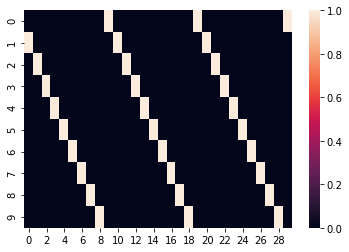

In [27]:
N_V = 100
N_H = 10
T = 30
n_batches = 500

h = create_BB(N_V=N_H, T=T, n_samples=n_batches, width_vec=[1], velocity_vec=[1], boundary=False, r=2)
sns.heatmap(h[:, :, 0])

Assign 10 visibles to each HU in VH

<AxesSubplot:>

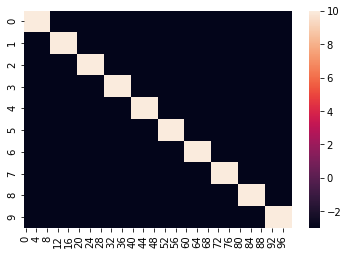

In [28]:
VH = torch.ones(N_H, N_V) * -3
for i in range(10):
    VH[i, i*10 : (i+1)*10] = 10 #5 * torch.randn(1)
sns.heatmap(VH)

<AxesSubplot:>

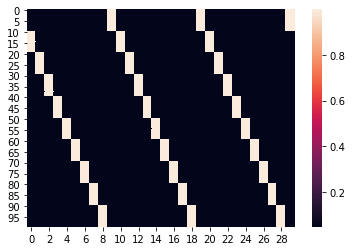

In [29]:
v = torch.sigmoid(torch.matmul(VH.T, h[:, :, 0]))
sns.heatmap(v[:, :100])

### Generate an RTRBM with pre-defined VH, HH and zero biases

<AxesSubplot:>

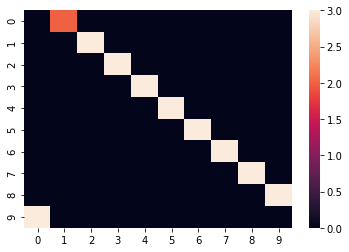

In [30]:
corr = np.zeros((N_H, N_H))
for i in range(N_H):
    for j in range(N_H):
        corr[i, j] = np.correlate(h[i,:-1, 0], h[j,1:, 0])
HH = torch.tensor(corr)
sns.heatmap(HH)

In [43]:
b_init = torch.zeros(1, N_H, dtype=torch.float)
b_V = torch.zeros(1, N_V, dtype=torch.float)
b_H = torch.zeros(1, N_H, dtype=torch.float)

data = torch.zeros(N_V, T, dtype=torch.float)
rtrbm = RTRBM(data, N_H=N_H, device='cpu')

rtrbm.W = torch.tensor(VH, dtype=torch.float)
rtrbm.W_acc = torch.tensor(HH, dtype=torch.float)
rtrbm.b_init = b_init
rtrbm.b_V = b_V
rtrbm.b_H = b_H

<ipython-input-43-8fcbc28a65bc>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rtrbm.W = torch.tensor(VH, dtype=torch.float)
<ipython-input-43-8fcbc28a65bc>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rtrbm.W_acc = torch.tensor(HH, dtype=torch.float)


### Now lets create some data

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 4820.63it/s]


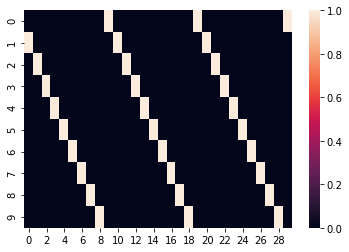

<AxesSubplot:>

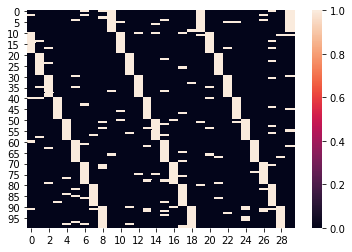

In [32]:
data = torch.zeros(N_V, T, n_batches)
for batch in tqdm(range(n_batches)):
    data[:, :, batch] = rtrbm.hidden_to_visible(h[:, :, batch])
    
sns.heatmap(h[:, :100, 0])
plt.show()
sns.heatmap(data[:, :100, 0])

### Train an RTRBM on this data

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:42<00:00,  5.83s/it]


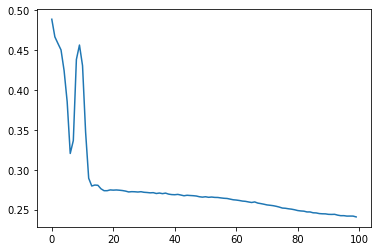

In [34]:
rtrbm_nobias = RTRBM_nobias(data, N_H=N_H, device='cpu')
rtrbm_nobias.learn(n_epochs=100, batchsize=100, CDk=10, mom=0.9, wc=0.0002, lr=1e-3)

plt.plot(rtrbm_nobias.errors)

In [42]:
rtrbm_nobias.learn(n_epochs=100, batchsize=100, CDk=5, mom=0.9, wc=0.0002, lr=1e-3)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:48<00:00,  3.48s/it]


In [35]:
W1 = rtrbm.W
W2 = rtrbm_nobias.W
W_acc1 = rtrbm.W_acc
W_acc2 = rtrbm_nobias.W_acc

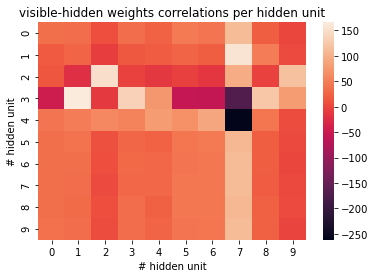

So, we have to shuffle the indexes of the weigths according to: [7. 7. 2. 1. 6. 7. 7. 7. 7. 7.]


In [36]:
corr = np.zeros((N_H, N_H))
shuffle_idx = np.zeros((N_H))
for i in range(N_H):
    for j in range(N_H):
        corr[i, j] = np.correlate(W1[i,:], W2[j,:])
    shuffle_idx[i] = np.argmax(corr[i,:])

plt.figure()
sns.heatmap(corr)
plt.title('visible-hidden weights correlations per hidden unit')
plt.xlabel('# hidden unit')
plt.ylabel('# hidden unit')
plt.show()

print('So, we have to shuffle the indexes of the weigths according to: ' + np.array2string(shuffle_idx))

In [37]:
W2 = W2[shuffle_idx, :]    
W_acc2 = W_acc2[shuffle_idx, :]
W_acc2 = W_acc2[:, shuffle_idx]

### Comparing the weights after alignment of hidden neurons

<AxesSubplot:>

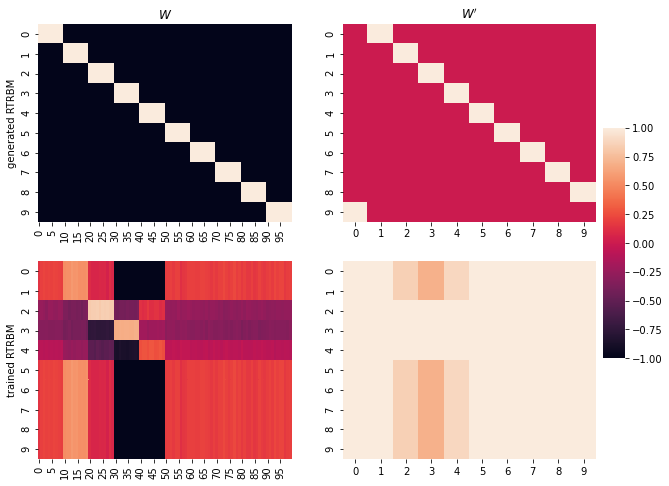

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
sns.heatmap(W1, ax=axes[0, 0], vmin=-1, vmax=1, cbar=True, cbar_ax=cbar_ax)
axes[0, 0].set_ylabel('generated RTRBM')
axes[0, 0].set_title('$W$')
sns.heatmap(W2, ax=axes[1, 0], vmin=-1, vmax=1, cbar=False)
axes[1, 0].set_ylabel('trained RTRBM')
sns.heatmap(W_acc1, ax=axes[0, 1], vmin=-1, vmax=1, cbar=False)
axes[0, 1].set_title('$W\'$')
sns.heatmap(W_acc2, ax=axes[1, 1], vmin=-1, vmax=1, cbar=False)

In [10]:
neurons = torch.arange(N_V)

fig, axes = plt.subplots(N_H, 1, figsize=(10,20))
for i, ax in enumerate(axes):
    ax.plot(neurons, W1[i, :])
    ax.plot(neurons, W2[i, :])
    ax.legend(['generated RTRBM', 'trained RTRBM'])
    ax.set_ylabel('hidden neuron ' + str(i))
    ax.set_xticks(np.arange(N_V))
    
axes[0].set_title('connection strength between visible and hidden units')
axes[2].set_xlabel('# visible neuron')

NameError: name 'N_V' is not defined

In [30]:
rtrbm = torch.load(open('D:/RU/OneDrive/Intern/rtrbm_master/data/Surrogate data/Reconstructing an RTRBM by hidden trace initial', 'rb'), map_location=torch.device('cpu'))
rtrbm1 = torch.load(open('D:/RU/OneDrive/Intern/rtrbm_master/data/Surrogate data/Reconstructing an RTRBM by hidden trace trained', 'rb'), map_location=torch.device('cpu'))

data_set = pickle.load(open('D:/RU/OneDrive/Intern/rtrbm_master/data/Surrogate data/Hidden_trace_1', 'rb'))

rtrbm.device='cpu'
rtrbm1.device='cpu'

In [31]:
[N, C_E, C_I, EI, IE, resolution, T, dt, T_step, spikes_true, spikes_train, spike_thres, I_inj, V] = data_set
h = torch.tensor(1.0 * (spikes_train > spike_thres), dtype=torch.float, device=device)[:, :350]

In [33]:
h = torch.tensor(1.0 * (spikes_train > spike_thres), dtype=torch.float, device='cpu')[:, :350]

<AxesSubplot:>

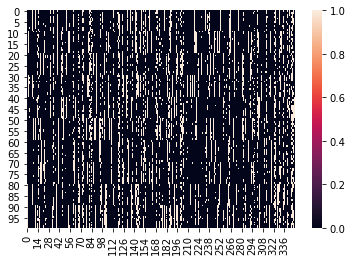

In [46]:
sns.heatmap(rtrbm1.V[:, :, 0])

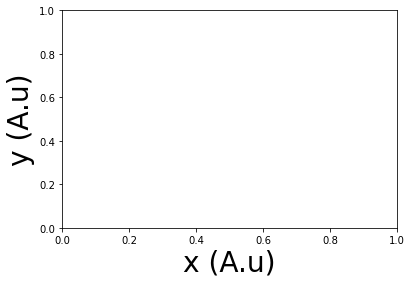

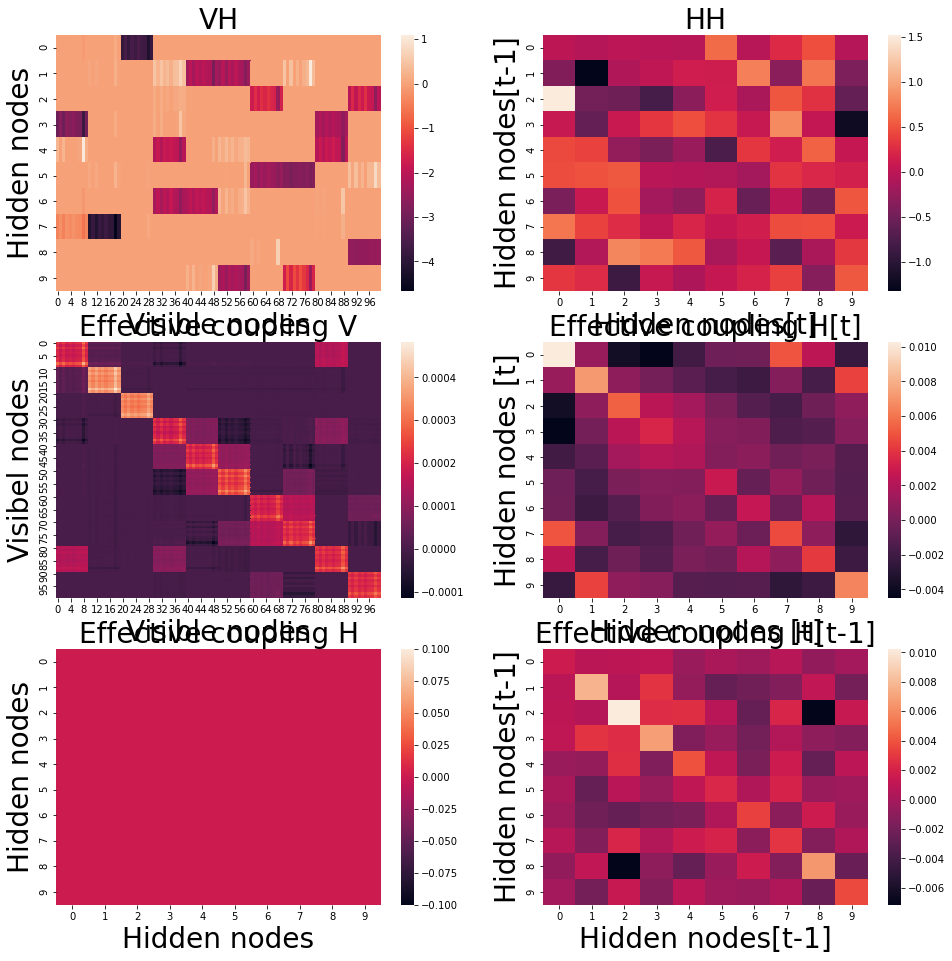

In [42]:
del plot_effective_coupling_VH_HH
from utils.plots import plot_effective_coupling_VH_HH
 
plot_effective_coupling_VH_HH(rtrbm1.W, rtrbm1.W_acc, rtrbm.V, h)

<AxesSubplot:>

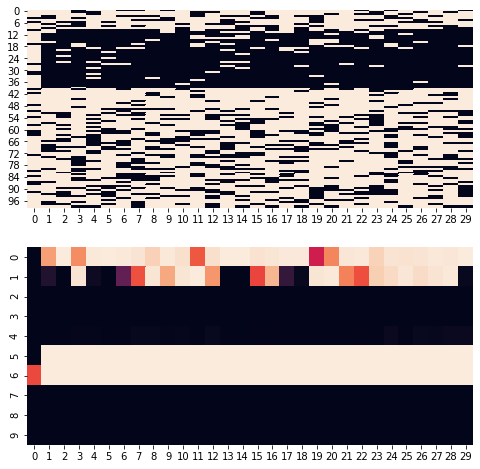

In [45]:
v_start = (torch.rand(N_V) > 0.2)*1.0
vt_infer, rt_infer = rtrbm_nobias.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
sns.heatmap(vt_infer, ax=ax[0], cbar=False)
sns.heatmap(rt_infer, ax=ax[1], cbar=False)

### Moment plots

In [46]:
vt_infer = torch.zeros(N_V, T, n_batches)
rt_infer = torch.zeros(N_H, T, n_batches)
for batch in tqdm(range(n_batches)):
    v_start = (torch.rand(N_V) > 0.2)*1.0
    vt_infer[:, :, batch], rt_infer[:, :, batch] = rtrbm.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [04:44<00:00,  1.76it/s]


In [ ]:
type(rtrbm.W)

In [ ]:
plot_moments(data.reshape(N_V, T*n_batches), h.reshape(N_H, T*n_batches), 
             vt_infer.reshape(N_V, T*n_batches), rt_infer.reshape(N_H, T*n_batches))

### Distribution of weights trained rtrbm / generated rtrbm

In [ ]:
plt.figure()
sns.kdeplot(rtrbm.W.ravel(), ax=plt.gca(), bw_adjust=0.05)
sns.kdeplot(rtrbm_nobias.W.ravel(), ax=plt.gca(), bw_adjust=0.05)
plt.xlabel('weight value')
plt.legend(['generated RTRBM', 'trained RTRBM'])